# News discover
## Author: Li Liu (ll782)

## Data source:
Collect data by News API, it is a simple and easy-to-use API that returns JSON metadata for the headlines currently published on a range of news sources.

A python script, read top/latest news from every source. data set includes attibutes of author, description, publishedAt, source, title, url, urlToImage, category, scraping_date. Furthermore, to reduce the data noise, scraping script support deduplication and null data removal, and save data into a csv file.

With the help of python lib newspaper3k, full text could be retrieved from url. Here only the short description is used for basic analysis, since description typically includes important information in the news.

## Environment
* Pyspark driven by Jupyter notebook
* anaconda python 3.5 integrated with:
    * nltk
    * sklearn
    * numpy
    * pandas
    * matplotlib
    

### Loading data into spark
Reading csv file into pandas dataframe, and then tranform it into spark dataframe. Although pandas dataframe has user friendly UI interface, to leverage spark in-memory map reduce computing power, data have to be loaded in RDD or spark dataframe. In this project, for showing results or invoking sklearn function which is not provided by pyspark, there is some convertion between pandas and spark dataframe.

In [1]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import col, length, udf
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import csv
import pandas as pd

In [2]:
# from csv import reader
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# pandas for data manipulation
pd.options.mode.chained_assignment = None


# csv file path
input_file_path = '/Users/liliu/workspace/newsapi/news_full_key_ner.csv'
output_file_path = '/Users/liliu/workspace/newsapi/news_clusterd_by_fulltext.csv'

data = pd.read_csv(input_file_path)

# Important merge keywords and named_entities to new columns
data["keywords_named_entities"] = data["keywords"]+'\n'+ data["named_entities"].fillna('')
# Important add doc_id to track document for labling topic
data['doc_id'] = data.index

# column name chosen for text analysis
text_col = 'fulltext'

schema = StructType([StructField('author',StringType(),True),
                     StructField('description',StringType(),True), 
                     StructField('publishedAt',StringType(),True),
                     StructField('source',StringType(),True),
                     StructField('title',StringType(),True),
                     StructField('url',StringType(),True),
                     StructField('urlToImage',StringType(),True),
                     StructField('category',StringType(),True),
                     StructField('scraping_date',StringType(),True),
                     StructField('fulltext',StringType(),True),
                     StructField('keywords',StringType(),True),
                     StructField('named_entities',StringType(),True),
                     StructField('keywords_named_entities',StringType(),True),
                     StructField('doc_id',IntegerType(),True),
                    ])
spdata = sqlContext.createDataFrame(data,schema)



print("total documents:", spdata.count())
print("analysis text in column:", text_col)

total documents: 675
analysis text in column: fulltext


In [3]:
data[:3]

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date,fulltext,keywords,named_entities,keywords_named_entities,doc_id
0,ABC News,The U.S. Navy says the search has ended for th...,2017-11-23T00:00:00Z,abc-news,Search ends for 3 US sailors missing in Navy a...,http://abcnews.go.com/International/wireStory/...,http://a.abcnews.com/images/International/Wire...,general,2017-11-24 00:34:00.129124,A search ended Friday for three sailors missin...,pascagoula mississippi\nuss ronald reagan\nfit...,japans\nreagan\nnavy\nuss fitzgerald\nfitzgera...,pascagoula mississippi\nuss ronald reagan\nfit...,0
1,ABC News,Four Dreamers momentarily halted the Macy's Th...,2017-11-23T00:00:00Z,abc-news,Dreamers stage protest during Macy's Thanksgiv...,http://abcnews.go.com/US/dreamers-stage-protes...,http://a.abcnews.com/images/US/daca-2-ht-er-17...,general,2017-11-24 00:34:00.129124,Four Dreamers momentarily halted the Macy's Th...,department of homeland security\ntrump adminis...,new york city\ncongress\nhector martinez\nwhit...,department of homeland security\ntrump adminis...,1
2,ABC News,Some Republicans are hoping lawmakers will soo...,2017-11-23T00:00:00Z,abc-news,Congressional Russia probes likely to head int...,http://abcnews.go.com/Politics/wireStory/congr...,http://a.abcnews.com/images/Politics/WireAP_b8...,general,2017-11-24 00:34:00.129124,Interested in Russia Investigation? Add Russia...,senate intelligence committee\nhouse intellige...,democrat\njared kushner\ndemocratic\ngeorge pa...,senate intelligence committee\nhouse intellige...,2


### Data cleaning
* Remove empty documents
* Remove document with desciprtions less the 100 charactor. Short description typically does not have enough meanful information, which create noise.
* Remove non english news source


In [4]:
spdata = spdata.na.drop()

spdata = spdata.dropDuplicates(['category', 'publishedAt','source','title'])
if text_col == 'description' or text_col == 'fulltext':
    spdata = spdata.filter(length(col(text_col)) > 100)

black_list=['buzzfeed','reddit-r-all','wired-de','gruenderszene','next-big-future','handelsblatt',
'spiegel-online','the-hindu','der-tagesspiegel','abc-news-au',
'mtv-news','the-times-of-india','wirtschafts-woche']
spdata = spdata.filter(spdata.source.isin(*black_list) == False)
print("Total valid documents:", spdata.count())

Total valid documents: 658


In [5]:
%matplotlib inline
# pandas for data manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
# nltk for nlp
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# list of stopwords like articles, preposition
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import re
import numpy as np


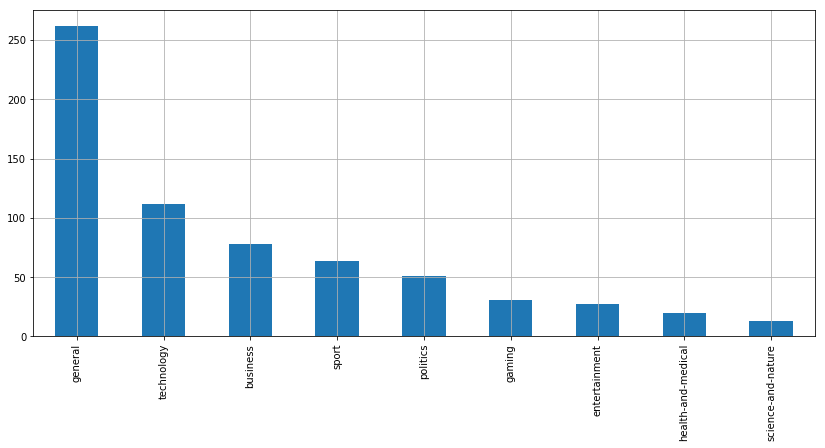

In [6]:
data = spdata.toPandas()
data.category.value_counts().plot(kind='bar', grid=True, figsize=(14, 6))

### News category analysis
From catergory histgram, it is clear to see most news articles are in the general category. And sport, business, enterainment and technology are people intered category.

Category just gives the basic infomation about articles, but to understand each documents' topic is a problem. After Examing the data from general category, news in general category are mixed topics. News articles classification only identify the article belongs to which category. But it cannot tell the topic and key infomation of the article.


### Key information extraction problem
Assuming each document contains a set of key information related a topic. Documents belongs to same topic, should have high similar of key information. Therefore, extract key information for each documents is the foundation for topics clustering.

This project is focus on how to extract key information from a news article.



#### 1. Tokenize documents is the first step to extract key words, follow natural language processing steps:
 - Split the documents into sentences and then split the sentences into tokens
 - Remove punctuation, stop words and special symbol
 - Lowercase all tokens

In [7]:
def keywords_named_entities_tokenizer(text):
    try:
        tokens = text.split('\n')
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        filtered_tokens = []
        for token in tokens:
            if token != 'NaN':
                filtered_tokens.append(token)
        return filtered_tokens
    except Exception as e:
        print(e)
        return None

def text_tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'ldquo', u'lsquo', u"rsquo", u'rdquo'
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Exception as e:
        print(e)
        return None

def tokenizer(text):
    keywords_columns=['keywords','named_entities','keywords_named_entities']
    if text_col in keywords_columns:
        return keywords_named_entities_tokenizer(text)
    else:
        return text_tokenizer(text)

In [8]:
sptokenizer = udf(tokenizer, ArrayType(StringType()))
spdata = spdata.withColumn('tokens', sptokenizer(spdata[text_col]))

Tokenizer wrapped by spark user defined function, and applied on every documents, genereate tokens stored in a column called 'tokens'. Here, it fist 5 documents after tokenize:

In [9]:
for row in spdata.head(5):
    print(text_col+':', row[text_col][0:100])
    print('tokens:', row.tokens[0:20])
    print('tokens count:', len(row.tokens))
    print('=================\n')

fulltext: “We’re being talked about again as an armed forces,” he said as a few club members lingered outside.
tokens: ['talked', 'armed', 'forces', 'said', 'club', 'members', 'lingered', 'outside', 'really', 'winning', 'know', 'win', 'let', 'win', 'letting', 'win', 'before.', 'continued', 'extolling', 'victories']
tokens count: 521

fulltext: With every passing minute, we draw closer to Sunday's much-anticipated Sean-Off.

That's right: Sean
tokens: ['every', 'passing', 'minute', 'draw', 'closer', 'sunday', 'much-anticipated', 'sean-off', 'right', 'sean', 'payton', 'high-flying', 'saints', 'upstart', 'rams', 'rowdy', 'points-generating', 'operation', 'conducted', 'first-year']
tokens count: 170

fulltext: Amazon debuted the original Echo a few years ago, and it raised eyebrows in the tech industry. The E
tokens: ['amazon', 'debuted', 'original', 'echo', 'years', 'ago', 'raised', 'eyebrows', 'tech', 'industry', 'echo', 'smart', 'home', 'speaker', 'houses', 'amazon', 'alexa', 'virtual',

#### 2. Top 10 tokens as key information for each documents
* The number of tokens for a short description is at least 15 words. Full text as description has more than 100 words. Count term frequecy on tokens, and select top 10 most common term as key information.

Here we can see, the top 10 keywords indeed captures the major information about the a topic, but contains a lot common words like 'us', 'one', 'said'.

In [10]:
top_keywords_number = 10
def top_k_keywords(tokens):
    counter = Counter(tokens)
    top_k = counter.most_common(top_keywords_number)
    return [i[0] for i in top_k]

spkeywords = udf(top_k_keywords, ArrayType(StringType()))
spdata = spdata.withColumn('key_tokens', spkeywords(spdata.tokens))
spdata.select(['doc_id','category', 'title', 'key_tokens']).limit(10).collect()


[Row(doc_id=118, category='general', title='A Mar-a-Lago Thanksgiving: It’s All Gravy', key_tokens=['mr.', 'trump', 'club', 'said', 'mar-a-lago', 'senecal', 'thanksgiving', 'holiday', 'president', 'guard']),
 Row(doc_id=209, category='sport', title="Sean McVay: I'm not in the same category as Payton", key_tokens=['payton', 'coach', 'think', 'mcvay', 'coaches', 'offensive', 'rams', 'know', 'sunday', 'line']),
 Row(doc_id=15, category='technology', title='Guidemaster: Want an Alexa device? Here’s every Amazon Echo, compared', key_tokens=['echo', 'alexa', 'amazon', 'yes', 'speaker', 'device', 'devices', 'connect', 'dot', 'home']),
 Row(doc_id=482, category='entertainment', title='This professional smartphone camera lens is on sale for Cyber Weekend', key_tokens=['revolcam', 'holiday', 'photo', 'use', 'season', 'want', 'smartphone', 'family', 'mashable', 'price']),
 Row(doc_id=521, category='general', title='Donald Trump’s first appearance in the Panama Papers has just been uncovered', key

### 3. Top 15 tokens in categories
Apply a series of map reduce on spdata to get top 15 key words:
 - Map task generates ( category, token) pairs
 - Redece task collect list of tokens for each category
 - Map task count top k keywords
    
Category general, business and politics contain 'trump' is the top key words as expected.
Since this three category are close related to president's decision.

Technology: ('x', 207), ('iphone', 184), ('apple', 139) in the top list.

Sport: has 'game' 'league' and 'football'

Common words like: 'says' 'said' and 'one' show up in the top list which are undesired.


In [11]:
top_keywords_number = 15
def map_category_keywords(row):
    return (row.category, row.tokens)

def reduce_by_category(all_tokens, tokens):
    return all_tokens + tokens

def map_top_k_keywords(category_tokens):
    counter = Counter(category_tokens[1])
    return (category_tokens[0], counter.most_common(top_keywords_number))
            
category_tokens = spdata.rdd.map(map_category_keywords) \
                        .reduceByKey(reduce_by_category) \
                        .map(map_top_k_keywords) \
                        .collect()

for row in category_tokens:
    print('category :', row[0])
    print('top ' + str(top_keywords_number) + ' key_tokens:', row[1])
    print('\n')

category : health-and-medical
top 15 key_tokens: [('may', 168), ('people', 96), ('diet', 82), ('person', 78), ('also', 77), ('weight', 66), ('help', 65), ('symptoms', 59), ('cells', 55), ('nose', 55), ('women', 55), ('cancer', 55), ('treatment', 54), ('pain', 52), ('one', 52)]


category : science-and-nature
top 15 key_tokens: [('people', 26), ('river', 24), ('animals', 22), ('dog', 21), ('whales', 19), ('one', 18), ('waves', 18), ('says', 17), ('like', 17), ('images', 17), ('light', 16), ('view', 16), ('also', 16), ('wave', 14), ('pets', 14)]


category : business
top 15 key_tokens: [('said', 234), ('trump', 185), ('year', 128), ('percent', 107), ('friday', 106), ('people', 98), ('would', 96), ('new', 87), ('also', 85), ('according', 85), ('thanksgiving', 74), ('time', 74), ('black', 73), ('online', 71), ('president', 68)]


category : technology
top 15 key_tokens: [('price', 470), ('one', 421), ('deal', 388), ('amazon', 337), ('like', 295), ('new', 271), ('best', 253), ('also', 246),

### 4. Topic discover
Using TfidfVectorizer to compute similarity between documents and a group of highly related documents form a topic

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

min_df = 5 if text_col == "description" or text_col == "full_text" else 1
print("use %s to calculate tfidf, min_df %d" % (text_col, min_df))
vzdata = spdata.orderBy([spdata.category.desc(), spdata.publishedAt.desc()]).select(['doc_id', text_col,'description','key_tokens','category','publishedAt','url']).toPandas()
vectorizer = TfidfVectorizer(min_df=min_df, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(vzdata[text_col]))
vz.shape


use fulltext to calculate tfidf, min_df 1


(658, 10000)

In [13]:
similarity_matrix = cosine_similarity(vz)
from matplotlib import pyplot as plt

#### 4.1 Similatity between category

From graph we can clearly see there are multiple category, there is low similarity between caregory. 

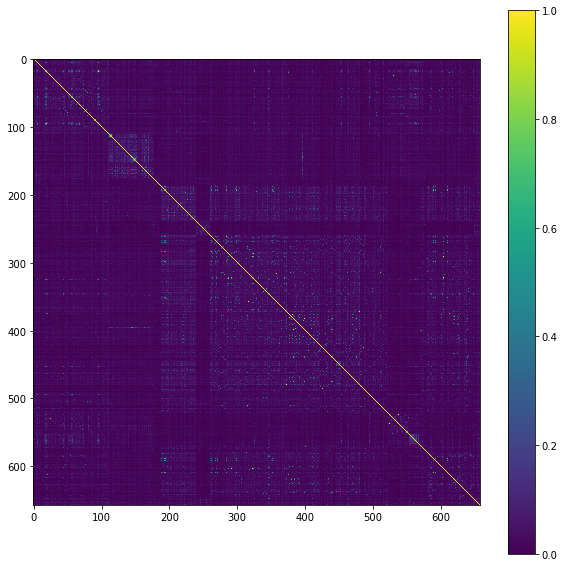

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(similarity_matrix, interpolation='none')
plt.colorbar()

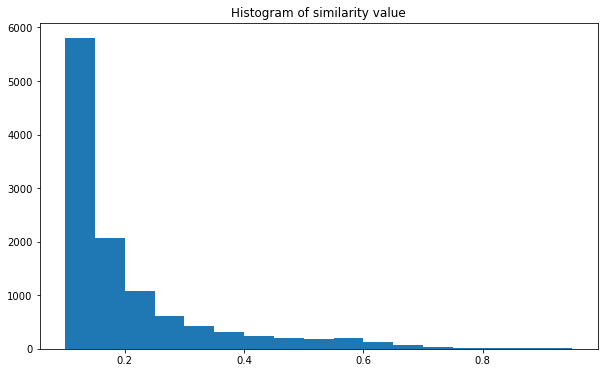

In [15]:
plt.figure(figsize = (10,6))
plt.hist(similarity_matrix.reshape(-1).tolist(), bins=np.arange(0.1, 1.0, 0.05))
plt.title("Histogram of similarity value")

#### 4.2 High Similatity documents
We define similarity above 0.55 as high similarity documents.

**Document 150** is about topic 'President Donald Trump in Japan', and all related documents also with similar keywords, well fitted in this topic.

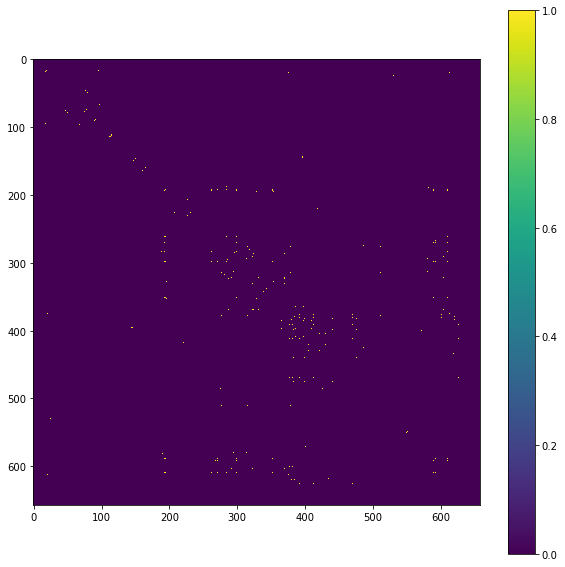

In [16]:
plt.figure(figsize = (10,10))
high_similarity_matrix = np.logical_and( similarity_matrix < 0.99 , similarity_matrix.round(decimals=1) >= 0.55)
plt.imshow(high_similarity_matrix, interpolation='none')
plt.colorbar()


In [17]:
from collections import Counter
def sample_similar_docs(similarity_matrix):
    similar_index = np.where(similarity_matrix == True)
    print('first 3 similarity document pairs')
    print(similar_index[0].tolist()[:3])
    print(similar_index[1].tolist()[:3])


    count = Counter(similar_index[0])
    most_common = count.most_common()
    print('\ntop-3 number of similar documents of each documents\n', most_common[:3])

    doc_idx = most_common[0][0]
    
    similarity_doc_index = np.where(similarity_matrix[doc_idx] == True )
    similarity_doc_index = np.append(similarity_doc_index, doc_idx)
    
    print("\ndocument similar to doc: ", doc_idx)
    print("is: ", similarity_doc_index)
    return similarity_doc_index.tolist()


In [18]:
print("high similarity documents:")
similarity_doc_index = sample_similar_docs(high_similarity_matrix)
pd.set_option('display.max_colwidth', 250)
vzdata.iloc[similarity_doc_index]

high similarity documents:
first 3 similarity document pairs
[4, 4, 4]
[90, 92, 101]

top-3 number of similar documents of each documents
 [(610, 13), (198, 13), (299, 13)]

document similar to doc:  610
is:  [193 195 198 262 271 284 299 300 313 352 353 589 592 610]


,doc_id,fulltext,description,key_tokens,category,publishedAt,url
193,602,"Top Democratic lawmakers and consumer-rights groups are blasting President Trump’s decision to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), superseding a chosen successor for the post.\n\nTrump nominated White H...","Top Democratic lawmakers and consumer-rights groups are blasting President Trump’s decision to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), superseding a chosen successor for the post.","[director, cfpb, mulvaney, consumer, trump, acting, said, act, financial, president]",politics,2017-11-25T16:29:58Z,http://thehill.com/policy/finance/361786-warren-waters-blast-trump-for-overriding-consumer-bureau-with-acting-director
195,596,"Senior White House officials insisted Saturday that President Trump is legally allowed to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), which is an independent agency.\n\nOfficials say Trump has the right to supe...","Senior White House officials insisted Saturday that President Trump is legally allowed to appoint an acting director for the Consumer Financial Protection Bureau, which is an independent agency.","[director, cfpb, mulvaney, trump, agency, said, official, officials, acting, president]",politics,2017-11-25T15:13:58Z,http://thehill.com/policy/finance/361778-white-house-calls
198,562,"President Donald Trump and the former director of Consumer Financial Protection Bureau are headed for a legal showdown. | Lee Jin-Man/Getty Images White House says Trump has right to name CFPB head, setting up clash\n\nThe White House on Saturday...","&quot;It seems like a pretty clear-cut legal question,&quot; a senior administration official told reporters.","[said, director, cordray, bureau, agency, cfpb, could, deputy, legal, financial]",politics,2017-11-25T13:03:51Z,https://www.politico.com/story/2017/11/25/white-house-cfpb-mulvaney-english-trump-190527
262,392,"Who's the boss? That's the awkward question after the departing head of a government agency charged with looking after consumer rights appointed a deputy to temporarily fill his spot. The White House then named its own interim leader.\n\nOne job,...","Who's the boss? That's the awkward question after the departing head of a government agency charged with looking after consumer rights appointed a deputy to temporarily fill his spot. The White House then named its own interim leader. One job, tw...","[agency, mulvaney, cordray, trump, said, director, house, english, cfpb, office]",general,2017-11-25T22:15:40Z,https://apnews.com/3ae9b3e863394f4593e73c2b443e264a
271,451,"(CNN) Former Rep. Barney Frank pushed back Saturday on the White House's assertion that President Donald Trump has the authority to appoint an interim director of the Consumer Financial Protection Bureau, saying the independence of watchdog agenc...","Former Rep. Barney Frank pushed back Saturday on the White House's assertion that President Donald Trump has the authority to appoint an interim director of the Consumer Financial Protection Bureau, saying the independence of watchdog agency was ...","[director, acting, house, serve, agency, white, law, independence, cordray, mulvaney]",general,2017-11-25T20:50:31Z,http://us.cnn.com/2017/11/25/politics/frank-cfpb-appointment/index.html
284,429,Who's the boss? That's the awkward question after the departing head of a government agency charged with looking after consumers' rights appointed a deputy to temporarily fill his spot. The White House then named its own interim leader.\n\nSo com...,Trump administration officials say they expect no trouble when President Trump's pick shows up for work,"[cordray, mulvaney, trump, agency, house, financial, english, director, office, pick]",general,2017-11-25T19:22:39+00:00,https://www.cbsnews.com/news/whos-the-boss-come-monday-at-consumer-agency/
299,655,"\n\nWhite House budget director Mick Mulvaney speaks at the Wh

#### 4.3 Medium similatity documents
We define similarity between 0.35 and 0.55 as medium similarity documents.

From **document 90 to document 100**, they are highly related to a topic. Exam the original documents, the topic is in sport category, all from website www.football-italia.net and all about italia football(to be clear it is soccer). But articles are not talking about an exact same event.


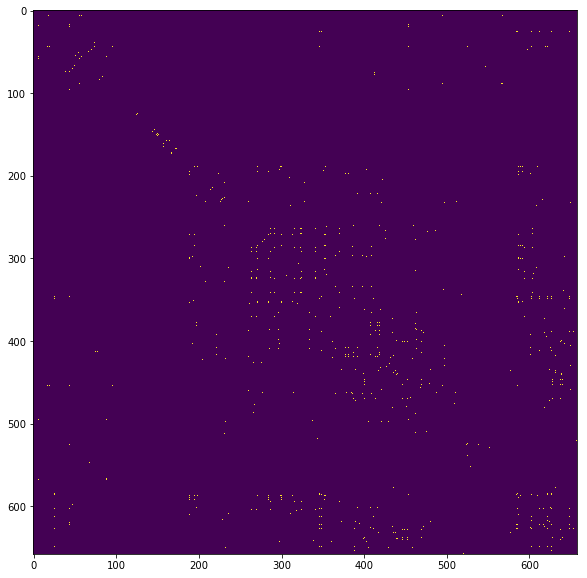

In [19]:
plt.figure(figsize = (10,10))
medium_similarity_matrix = np.logical_and(similarity_matrix < 0.55, similarity_matrix > 0.35)

plt.imshow(medium_similarity_matrix, interpolation='none')


In [20]:
print("medium similarity documents:")
similarity_doc_index = sample_similar_docs(medium_similarity_matrix)
pd.set_option('display.max_colwidth', 250)
vzdata.iloc[similarity_doc_index]

medium similarity documents:
first 3 similarity document pairs
[6, 6, 6]
[18, 54, 56]

top-3 number of similar documents of each documents
 [(587, 14), (189, 12), (268, 12)]

document similar to doc:  587
is:  [189 193 195 198 262 271 284 299 300 313 352 353 589 610 587]


,doc_id,fulltext,description,key_tokens,category,publishedAt,url
189,598,"President Trump on Saturday defended his decision to appoint an acting director for the Consumer Financial Protection Bureau (CFPB) despite the outgoing head naming a temporary successor, calling the agency a ""total disaster"" under officials from...","Trump says Obama's picks to lead the Consumer Financial Protection Bureau (CFPB) were a ""disaster.""","[trump, director, financial, consumer, officials, bureau, protection, house, total, cfpb]",politics,2017-11-25T22:19:32Z,http://thehill.com/blogs/blog-briefing-room/361814-trump-defends-decision-to-appoint-consumer-bureau-chief-agency-a
193,602,"Top Democratic lawmakers and consumer-rights groups are blasting President Trump’s decision to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), superseding a chosen successor for the post.\n\nTrump nominated White H...","Top Democratic lawmakers and consumer-rights groups are blasting President Trump’s decision to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), superseding a chosen successor for the post.","[director, cfpb, mulvaney, consumer, trump, acting, said, act, financial, president]",politics,2017-11-25T16:29:58Z,http://thehill.com/policy/finance/361786-warren-waters-blast-trump-for-overriding-consumer-bureau-with-acting-director
195,596,"Senior White House officials insisted Saturday that President Trump is legally allowed to appoint an acting director for the Consumer Financial Protection Bureau (CFPB), which is an independent agency.\n\nOfficials say Trump has the right to supe...","Senior White House officials insisted Saturday that President Trump is legally allowed to appoint an acting director for the Consumer Financial Protection Bureau, which is an independent agency.","[director, cfpb, mulvaney, trump, agency, said, official, officials, acting, president]",politics,2017-11-25T15:13:58Z,http://thehill.com/policy/finance/361778-white-house-calls
198,562,"President Donald Trump and the former director of Consumer Financial Protection Bureau are headed for a legal showdown. | Lee Jin-Man/Getty Images White House says Trump has right to name CFPB head, setting up clash\n\nThe White House on Saturday...","&quot;It seems like a pretty clear-cut legal question,&quot; a senior administration official told reporters.","[said, director, cordray, bureau, agency, cfpb, could, deputy, legal, financial]",politics,2017-11-25T13:03:51Z,https://www.politico.com/story/2017/11/25/white-house-cfpb-mulvaney-english-trump-190527
262,392,"Who's the boss? That's the awkward question after the departing head of a government agency charged with looking after consumer rights appointed a deputy to temporarily fill his spot. The White House then named its own interim leader.\n\nOne job,...","Who's the boss? That's the awkward question after the departing head of a government agency charged with looking after consumer rights appointed a deputy to temporarily fill his spot. The White House then named its own interim leader. One job, tw...","[agency, mulvaney, cordray, trump, said, director, house, english, cfpb, office]",general,2017-11-25T22:15:40Z,https://apnews.com/3ae9b3e863394f4593e73c2b443e264a
271,451,"(CNN) Former Rep. Barney Frank pushed back Saturday on the White House's assertion that President Donald Trump has the authority to appoint an interim director of the Consumer Financial Protection Bureau, saying the independence of watchdog agenc...","Former Rep. Barney Frank pushed back Saturday on the White House's assertion that President Donald Trump has the authority to appoint an interim director of the Consumer Financial Protection Bureau, saying the independence of watchdog agency was ...","[director, acting, house, serve, agency, white, law, independence, cordray, mulvaney]",general,2017-11-25T20:50:31Z,http://us.cnn.com/2017/11/25/politics/frank-cfpb-appointment/index.html
284,429,Who's the boss? Th

In [21]:
import lda
from sklearn.feature_extraction.text import CountVectorizer
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
output_notebook()
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

Loading BokehJS ...

In [22]:
min_df = 5 if text_col == "description" or text_col == "full_text" else 3
print("use %s to vectorizer , min_df = %d" % (text_col, min_df))

use fulltext to vectorizer , min_df = 3


In [23]:
cvectorizer = CountVectorizer(min_df=min_df, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(list(vzdata[text_col]))

n_topics = 30
print("cluster by %d topic" %(n_topics))
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

cluster by 30 topic


In [24]:
# Assign topic to each document
doc_topic = lda_model.doc_topic_
lda_keys = []

for i, doc_id in enumerate(list(vzdata['doc_id'])):
    lda_keys += [doc_topic[i].argmax()]
    
vzdata['topic_id'] = lda_keys



In [25]:
import collections
topic_vzdata_idx_dict = collections.defaultdict(list)
topic_doc_dict = collections.defaultdict(list)
for i, topic_id in enumerate(list(vzdata['topic_id'])):
    topic_vzdata_idx_dict[topic_id].append(i)
    topic_doc_dict[topic_id].append(vzdata['doc_id'][i])

n_top_words = 20
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()

for topic_id in topic_doc_dict:
#     print('Topic %d, vzdata_index: %s' % (topic_id, topic_vzdata_idx_dict[topic_id]))
    print('Topic %d\ncsv doc_id: %s' % (topic_id, topic_doc_dict[topic_id]))
    topic_dist = topic_word[topic_id]
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print("top-%d keywords: %s\n" % (n_top_words, ', '.join(topic_words)))

#Note that vzdata_index is different from doc_is, since vzdata is sorted results of csv data

Topic 0
csv doc_id: [640, 383, 384, 259, 18, 306, 97, 268, 249, 174, 352, 318]
top-20 keywords: facebook, use, data, uber, users, internet, using, service, information, people, company, systems, security, companies, us, breach, access, services, google, net

Topic 1
csv doc_id: [634, 260, 478, 125, 238, 479, 474, 129, 127]
top-20 keywords: december, series, season, marvel, frank, batman, movie, story, punisher, billy, stories, netflix, cowboy, new, videos, youtube, image, character, kids, content

Topic 2
csv doc_id: [455, 470, 433, 295, 177, 338, 69, 26, 293, 285, 179, 117, 333, 0, 341, 42, 324]
top-20 keywords: navy, said, submarine, u.s., sailors, search, us, fleet, ships, japan, crew, uss, aircraft, miles, argentine, air, autoplay, missing, san, three

Topic 3
csv doc_id: [379, 635, 591, 265, 266, 569]
top-20 keywords: switch, watch, nintendo, apple, nintendo switch, apple watch, screen, display, new, bundle, design, best, super, hardware, 're, image, mario, nike, series, x

Topic 

In [26]:

csv_to_save = data.merge(vzdata.loc[:,['doc_id','topic_id']], left_on='doc_id', right_on='doc_id', how='inner')
csv_to_save = csv_to_save.sort_values(by=['doc_id'])
#save clustered results
csv_to_save.to_csv(output_file_path, encoding='utf-8', index=False)

In [27]:
csv_to_save.query('topic_id==14')

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date,fulltext,keywords,named_entities,keywords_named_entities,doc_id,topic_id
100,Derek Lawrence,"Like many celebrities on Thursday, Uma Thurman wished her fans a happy Thanksgiving on social media. But the Kill Bill star also used the post to send a strong message to Harvey Weinstein and his “wicked conspirators.”\n\nThe Oscar-nominated actr...",2017-11-23T21:49:23Z,entertainment-weekly,Uma Thurman slams Harvey Weinstein: 'You don't deserve a bullet',http://ew.com/movies/2017/11/23/uma-thurman-harvey-weinstein-thanksgiving/,https://ewedit.files.wordpress.com/2017/11/gettyimages-689434288.jpg?crop=0px%2C0px%2C2700px%2C1419px&resize=1200%2C630,entertainment,2017-11-24 00:34:00.129124,"Like many celebrities on Thursday, Uma Thurman wished her fans a happy Thanksgiving on social media. But the Kill Bill star also used the post to send a strong message to Harvey Weinstein and his “wicked conspirators.”\n\nThe Oscar-nominated actr...",new york los angeles beverly hills\nweinsteinproduced\nquentin tarantino\noscarnominated\nharvey weinstein\nthanksgiving\ncelebrities\naccusations\ndaryl hannah\nmisconduct\nconspirators\nevergrowing\ninvestigation\nallegations\numa thurman\nwein...,daryl hannah\numa thurman\ntarantino\nhannah\nharvey weinstein\nharvey\nthurman\nuk\nnew york los angeles beverly hills\nbill “i\nweinstein\nquentin tarantino,new york los angeles beverly hills\nweinsteinproduced\nquentin tarantino\noscarnominated\nharvey weinstein\nthanksgiving\ncelebrities\naccusations\ndaryl hannah\nmisconduct\nconspirators\nevergrowing\ninvestigation\nallegations\numa thurman\nwein...,103,14
394,THR Staff,"""Happy Thanksgiving everyone! Except you Harvey, and all your wicked conspirators - I’m glad it’s going slowly - you don’t deserve a bullet,"" she wrote in a post on her Instagram.",2017-11-24T00:13:00+00:00,google-news,"Uma Thurman to Harvey Weinstein: ""You Don't Deserve a Bullet""",https://www.hollywoodreporter.com/news/uma-thurman-harvey-weinstein-you-dont-deserve-a-bullet-1061298,https://cdn1.thr.com/sites/default/files/2017/11/uma_thurman.jpg,general,2017-11-24 00:34:00.129124,"""Happy Thanksgiving everyone! Except you Harvey, and all your wicked conspirators — I’m glad it’s going slowly — you don’t deserve a bullet,"" she wrote in a post on her Instagram.\n\nUma Thurman wants to wish everyone a happy Thanksgiving — every...",los angeles beverly hills new york\nthanksgiving\nharvey weinstein\nconspirators\nharvey\neveryone\numa thurman\nharassment\nweinstein\ninstagram\nparisian\nhollywood\nfranchise\nthursday\nthurman\nstatement\nwicked\ninterview\nbullet\nhappy,parisian\numa thurman\nlondon\nharvey\nthurman\nharvey weinstein\nlos angeles beverly hills new york\nweinstein,los angeles beverly hills new york\nthanksgiving\nharvey weinstein\nconspirators\nharvey\neveryone\numa thurman\nharassment\nweinstein\ninstagram\nparisian\nhollywood\nfranchise\nthursday\nthurman\nstatement\nwicked\ninterview\nbullet\nhappy\npar...,119,14
493,Caitlin Yilek,At least four women have accused the Minnesota senator of inappropriately touching them.,2017-11-24T00:54:00+00:00,google-news,"Al Franken apologizes again, signals he'll fight to stay in the Senate",http://www.washingtonexaminer.com/al-franken-apologizes-again-signals-hell-fight-to-stay-in-the-senate/article/2641617,http://cdn.washingtonexaminer.biz/cache/1060x600-ae380957d007c982c5eb4104137ef4c9.jpg,general,2017-11-24 00:34:00.129124,"Minnesota Sen. Al Franken issued another apology on Thanksgiving to women who have accused him of groping them, but indicated he intends to stay in the Senate, and said he would start working to rebuild the trust of voters in Minnesota.\n\n""I fee...",senate ethics committee\nand\nhuffington post\nleeann tweeden\nminnesota\ninappropriate\ndemocratic\ninvestigation\nfirst senate\nlindsay menz\nminnesotans\nphotographs\nsituations\nsenate\nallegations\nstatement\nal franken\nthousa

### visualization of LDA clustering

In [32]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 658 samples in 0.001s...
[t-SNE] Computed neighbors for 658 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 658 / 658
[t-SNE] Mean sigma: 0.197158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.960556
[t-SNE] Error after 1000 iterations: 0.552060


In [36]:
plot_lda = bp.figure(plot_width=700, plot_height=700, title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [38]:
lda_data_source = csv_to_save

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])

lda_df['doc_id'] = list(lda_data_source['doc_id'])
lda_df['description'] = list(lda_data_source['description'])
lda_df['category'] = list(lda_data_source['category'])
if text_col != 'fulltext' and text_col != 'description':
    lda_df['text_col'] = list(lda_data_source[text_col])

colormap60 = np.concatenate((colormap, colormap)) 
lda_df['color'] = colormap60[lda_keys]

lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

plot_lda.scatter(source=lda_df, x='x', y='y', color='color')

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description", "topic":"@topic", "category":"@category", "doc_id":"@doc_id"}
# hover.tooltips={"text_col": "@text_col", "description":"@description", "topic":"@topic", "category":"@category", "doc_id":"@doc_id"}

    
show(plot_lda)

## Conclusion: common keywords problem

As stated before, the key information extraction is the foundation of topic clustering.
* Extraction sololy based on term frequency contains large amount commone words.
* Tf-idf similarity of full text documents provide limit feature for clusting topics. 
* Only high similarity documents belongs to a topic.

Next step is use a key informatin extraction model to improve documents similarity.

## Future work
* The proposed key word extraction model based on terms' features: noun, named entity, wiki words, capitalized, tf, tf-idf, position, also in title, etc.

* Documents key infomation include extracted key words and also should input geo entiry and time infomation. 

* Dataset https://github.com/zelandiya/keyword-extraction-datasets.

## Acknowledge
1. https://newsapi.org/
2. https://gist.github.com/ahmedbesbes/4597996515e4bb7961825d4c13ea6aff#file-news-py
3. http://www.nltk.org/
4. https://github.com/zelandiya/keyword-extraction-datasets
5. http://pythonhosted.org/lda/
6. https://github.com/lvsh/keywordfinder